In [3]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

## Load Training Data

In [4]:
train_dataset = pd.read_csv("/Users/danielguarnizo/workspace/HACK4SDS/Dataset_DAY1/Data/train_set.csv", delimiter=';')

In [5]:
train_dataset.head()

,application_ID,decision_date,company_ID,external_score_ver01,external_score_ver02,late_payment_score,external_score_late_payment_integrated,external_score_moderate,external_score_adverse,external_score_ver03,...,avg_count_enti_affidanti,std_count_enti_affidanti,max_count_enti_affidanti,last_count_enti_affidanti,avg_count_numero_prima_info,std_count_numero_prima_info,max_count_numero_prima_info,last_count_numero_prima_info,days_to_default,target
0,a1Q7R00000ej2yjUAA,2021-11-30,7256587870,10,3,NaN,NaN,NaN,NaN,MISSING,...,1,0,1,1,0,0,0,0,522,1
1,a1Q2X00000ZWC5LUAX,2020-10-06,6178307100,7,3,NaN,NaN,NaN,NaN,H,...,1,0,1,1,2,0,2,2,1498,0
2,a1Q2X00000XcCCQUA3,2020-02-11,7692855390,7,3,NaN,NaN,NaN,NaN,MISSING,...,1,0,1,1,1,0,1,1,779,1
3,a1Q7R00000ejSs3UAE,2022-01-18,5752241730,8,2,NaN,NaN,NaN,NaN,MISSING,...,1,0,1,1,"0,5","0,522232967867094",1,0,1498,0
4,a1Q7R00000eiRidUAE,2021-09-16,7533506540,4,1,NaN,NaN,NaN,NaN,MISSING,...,0,0,0,0,0,0,0,0,1498,0


## Analizing Data

In [2]:
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [8]:
train_dataset.describe()

,external_score_ver01,external_score_ver02,late_payment_score,external_score_late_payment_integrated,external_score_moderate,external_score_adverse,age,last_statement_age,max_count_enti_affidanti,last_count_enti_affidanti,max_count_numero_prima_info,last_count_numero_prima_info,days_to_default,target
count,32032.000000,32032.000000,4544.000000,4544.000000,4824.000000,4824.000000,32032.000000,32032.000000,32032.000000,32032.000000,32032.000000,32032.000000,32032.000000,32032.000000
mean,6.772040,1.942433,9.286532,5.891505,6.039594,6.168947,8.972715,1.824894,2.928571,2.691964,1.146354,0.976773,1281.800356,0.215222
std,1.764166,0.786342,2.760645,1.244978,1.302913,1.343487,9.003956,0.621009,3.321439,3.105271,1.494643,1.314287,426.997217,0.410983
min,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,6.000000,1.000000,7.000000,5.000000,5.000000,5.000000,3.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1498.000000,0.000000
50%,6.000000,2.000000,9.000000,6.000000,6.000000,6.000000,6.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1498.000000,0.000000
75%,8.000000,3.000000,10.000000,7.000000,7.000000,7.000000,11.000000,2.000000,4.000000,4.000000,2.000000,1.000000,1498.000000,0.000000
max,10.000000,3.000000,20.000000,10.000000,10.000000,10.000000,106.000000,7.000000,50.000000,45.000000,12.000000,12.000000,1498.000000,1.000000


In [7]:
train_dataset.values.sum()

TypeError: can only concatenate str (not "int") to str

<Axes: xlabel='target', ylabel='count'>

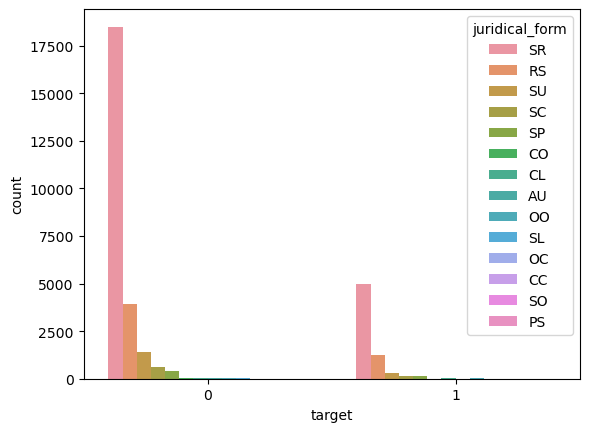

In [6]:
sns.countplot(x='target', hue= 'juridical_form', data= train_dataset)

## Clean and encode Data

#### Drop unneeded columns

In [4]:
## drop featurs 
train_dataset= train_dataset.drop(columns=['days_to_default', 'application_ID', 'decision_date', 'company_ID'])


#### Find columns with to many Nan's values

In [5]:
column_names = train_dataset.columns.tolist()
drop_columns = []
for name in column_names:
    nan_count = train_dataset[name].isna().sum()
    print(f"column {name}: {nan_count}")
    if (nan_count/28000) > 0.5:
        print(f"Number of NaN values in column '{name}': {nan_count}")
        drop_columns.append(name)

column external_score_ver01: 0
column external_score_ver02: 0
column late_payment_score: 27488
Number of NaN values in column 'late_payment_score': 27488
column external_score_late_payment_integrated: 27488
Number of NaN values in column 'external_score_late_payment_integrated': 27488
column external_score_moderate: 27208
Number of NaN values in column 'external_score_moderate': 27208
column external_score_adverse: 27208
Number of NaN values in column 'external_score_adverse': 27208
column external_score_ver03: 0
column age: 0
column province: 2654
column juridical_form: 0
column industry_sector: 0
column gross_margin_ratio: 0
column core_income_ratio: 0
column cash_asset_ratio: 0
column consolidated_liabilities_ratio: 0
column tangible_assets_ratio: 0
column revenues: 0
column cr_available: 0
column region: 0
column geo_area: 0
column last_statement_age: 0
column overrun_freq_a_revoca_autoliquidanti: 0
column avg_tension_a_revoca_autoliquidanti: 0
column std_tension_a_revoca_autoliqui

#### Drop columns with to many Nan's

In [6]:
train_dataset = train_dataset.drop(columns=drop_columns)

#### Count values and categories in columns 

In [7]:
# Assuming df is your DataFrame and column_name is the column you want to analyze
column_name = 'your_column_name'
categories_counts = train_dataset['gross_margin_ratio'].value_counts()

print("Unique categories and their counts:")
print(categories_counts)

Unique categories and their counts:
gross_margin_ratio
0,464636707194417     1372
0,229961682960403      888
0,457290586725803      563
0,481464142837938      162
0,380200857643313      111
                      ... 
0,293528780836611        1
0,0237529691211401       1
0,42741935483871         1
0,609195402298851        1
0,42722305017387         1
Name: count, Length: 20607, dtype: int64


#### Label enconding

In [8]:
def Replace_cate_to_value(column_name):
    # Extract categories

    # Extract unique category names from the column
    unique_categories = train_dataset[column_name].unique()

    # convert 'numpy.ndarray' in to a python list
    l = unique_categories.tolist()

    # print("Unique categories in the column:")
    # print(l)
    if 'MISSING' in l:
        l.remove('MISSING')
        l.sort(reverse=True)
    # print(unique_categories)

    # print(f"remove{l}")
    dic = { l[i]:i+1 for i in range(0, len(l))}

    # dic = {}

    # for name in unique_categories:
    #     if name != "MISSING":
    #         dic{}
    # print(dic)

    # Replace values in the column based on the dictionary mapping
    train_dataset[column_name] = train_dataset[column_name].replace(dic)
    # print(train_dataset[column_name])

    # print("Updated DataFrame:")
    # print(train_dataset[column_name])

In [9]:
column_names = ['industry_sector', 'region', 'geo_area','external_score_ver03', 'province','juridical_form']
for column_name in column_names:
    Replace_cate_to_value(column_name)

/var/folders/sq/lqj95by96lnccb74l6fsytf00000gn/T/ipykernel_479/2074430642.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dataset[column_name] = train_dataset[column_name].replace(dic)


#### Replace True and False values to numerical values in Columns

In [10]:
train_dataset['cr_available'] = [int(train_dataset['cr_available'][i]) for i in range(len(train_dataset['cr_available']))]
train_dataset['cr_available']

0        1
1        1
2        0
3        1
4        0
        ..
32027    1
32028    1
32029    1
32030    1
32031    1
Name: cr_available, Length: 32032, dtype: int64

#### Mean of external score var 03 

In [11]:
s0, s1, c0, c1 = 0,0,0,0
unique_labels = train_dataset['target'].unique()
for index, row in train_dataset.iterrows():
    if row['external_score_ver03'] != 'MISSING':
        if row['target'] == 0:
            s0 += row['external_score_ver03']
            c0 +=1
        elif row['target'] == 1:
            s1 += row['external_score_ver03']
            c1 += 1

m0 = round(s0/c0)
m1 = round(s1/c1)
print(m0)
print(m1)

8
10


#### Replace MISSING values to Mean finded 

In [12]:
# Assuming df is your DataFrame and 'column_to_change' is the column you want to change
# 'condition_column' is the column based on which you want to change the content
train_dataset.loc[(train_dataset['target'] == 1) & (train_dataset['external_score_ver03'] == 'MISSING'), 'external_score_ver03'] = m1
train_dataset.loc[(train_dataset['target'] == 0) & (train_dataset['external_score_ver03'] == 'MISSING'), 'external_score_ver03'] = m0
train_dataset['external_score_ver03']

# For example, if you want to change the content of 'column_to_change' to 'new_value' where 'condition_column' is True
# Replace 'new_value', 'column_to_change', and 'condition_column' with your actual values

0        10
1         7
2        10
3         8
4         8
         ..
32027    10
32028     5
32029    10
32030     9
32031    10
Name: external_score_ver03, Length: 32032, dtype: object

## Normalise Datase

#### Replace the "," to ".", in such a way to pass from object to number

In [13]:
# Replace commas with periods in all columns
train_dataset = train_dataset.replace(',', '.', regex=True)


/var/folders/sq/lqj95by96lnccb74l6fsytf00000gn/T/ipykernel_479/3884997620.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dataset = train_dataset.replace(',', '.', regex=True)


In [14]:
pd.set_option('display.max_columns', None)
train_dataset.head(30)

,external_score_ver01,external_score_ver02,external_score_ver03,age,province,juridical_form,industry_sector,gross_margin_ratio,core_income_ratio,cash_asset_ratio,consolidated_liabilities_ratio,tangible_assets_ratio,revenues,cr_available,region,geo_area,last_statement_age,overrun_freq_a_revoca_autoliquidanti,avg_tension_a_revoca_autoliquidanti,std_tension_a_revoca_autoliquidanti,max_tension_a_revoca_autoliquidanti,last_tension_a_revoca_autoliquidanti,avg_rel_used_a_revoca_autoliquidanti,std_rel_used_a_revoca_autoliquidanti,max_rel_used_a_revoca_autoliquidanti,last_rel_used_a_revoca_autoliquidanti,overrun_freq_a_scadenza,avg_rel_used_a_scadenza,std_rel_used_a_scadenza,max_rel_used_a_scadenza,last_rel_used_a_scadenza,avg_count_enti_affidanti,std_count_enti_affidanti,max_count_enti_affidanti,last_count_enti_affidanti,avg_count_numero_prima_info,std_count_numero_prima_info,max_count_numero_prima_info,last_count_numero_prima_info,target
0,10,3,10,15,1,1,1,0.464636707194417,0.0125934084914631,0,0.416001808268284,1,410,1,1,1,2,0,0,0,0,0,0,0,0,0,0.25,0.176974593495935,0.00211193175908977,0.179073170731707,0.172031707317073,1,0,1,1,0,0,0,0,1
1,7,3,7,5,2,2,2,0.372340425531915,0.115384615384615,0.235955056179775,0.484042553191489,1,208,1,2,1,3,0,0,0,0,0,0,0,0,0,0,0.151754006410256,0.00680628616351487,0.164754807692308,0.146384615384615,1,0,1,1,2,0,2,2,0
2,7,3,10,5,3,1,3,0.27,0.00636942675159236,0.359375,0.125,0.375,471,0,3,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,1
3,8,2,8,6,4,1,1,0.419928825622776,0.152173913043478,0.136150234741784,0.765124555160142,0.0588235294117647,598,1,4,3,3,0,0,0,0,0,0,0,0,0,0,0.0250836120401338,0.0261989783210917,0.0501672240802676,0.0501672240802676,1,0,1,1,0.5,0.522232967867094,1,0,0
4,4,1,8,5,5,1,1,0.526315789473684,0.0833333333333333,0.233333333333333,0.197368421052632,0.75,108,0,5,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,1,12,2,6,1,4,0.673177083333333,0.0266086115142719,0.192248062015504,0.252604166666667,0.504065040650406,2073,1,6,5,1,0,0,0,0,0,0,0,0,0,0.25,0.0606801736613604,0.0372223615134005,0.146051133622769,0.146051133622769,2.25,0.452267016866645,3,3,2.91666666666667,0.668557923421522,4,1,0
6,7,3,10,3,7,2,1,1.66666666666667,0.0175438596491228,0.615384615384615,0.277777777777778,0,57,0,7,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,6,1,10,9,8,1,5,0.307391091532061,0.0106478827094766,0.0802713397399661,0.157611355849241,0.843065693430657,12209,1,8,5,3,0,0.458544592472176,0.24858416993045,0.790274988115683,0.202147164167984,0.0276098916100145,0.0138428111031345,0.0453427799164551,0.0124443443361455,0,0.0202318371693013,0.0200253015832131,0.0409533950364485,0.0377952330248178,6,0,6,6,0.25,0.621581560508061,2,2,1
8,10,3,10,2,9,1,2,0.457290586725803,0.0688915656160738,0,0.369088503259972,1,584,1,9,2,2,0.0833333333333333,12637,43775.5371931111,151643,1,0.00285559360730594,0.00988559726757798,0.0342465753424658,0.0342465753424658,0,0.0942785388127854,0.000436037129675016,0.0950171232876712,0.0950171232876712,1,0,1,1,1,0,1,1,1
9,7,2,8,12,10,3,6,0.221461187214612,-0.0452898550724638,0.0517241379310345,0.0810502283105023,0.715017064846416,552,0,10,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
train_dataset = train_dataset.astype('float32')

In [59]:
# Assuming train_dataset is your DataFrame
has_nan_values = train_dataset.isna().any().any()

if has_nan_values:
    print("DataFrame contains NaN values.")
else:
    print("DataFrame does not contain any NaN values.")

DataFrame does not contain any NaN values.


In [60]:
# Assuming train_dataset is your DataFrame
column_types = train_dataset.dtypes

print("Data types of each column:")
print(column_types)

Data types of each column:
external_score_ver01                     float32
external_score_ver02                     float32
external_score_ver03                     float32
age                                      float32
province                                 float32
juridical_form                           float32
industry_sector                          float32
gross_margin_ratio                       float32
core_income_ratio                        float32
cash_asset_ratio                         float32
consolidated_liabilities_ratio           float32
tangible_assets_ratio                    float32
revenues                                 float32
cr_available                             float32
region                                   float32
geo_area                                 float32
last_statement_age                       float32
overrun_freq_a_revoca_autoliquidanti     float32
avg_tension_a_revoca_autoliquidanti      float32
std_tension_a_revoca_autoliquidanti      f

#### Normalise Columns

In [63]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Sample DataFrame
data = {
    'A': [10, 20, 30, 40, 50],
    'B': [100, 200, 300, 400, 500],
    'C': [1000, 2000, 3000, 4000, 5000]
}
df = pd.DataFrame(data)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize columns
normalized_data = scaler.fit_transform(df)

# Convert back to DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=df.columns)

print(normalized_df)


      A     B     C
0  0.00  0.00  0.00
1  0.25  0.25  0.25
2  0.50  0.50  0.50
3  0.75  0.75  0.75
4  1.00  1.00  1.00


## Model

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import CrossEntropyLoss

#### Quello che funziona 

In [67]:
# Assuming you have loaded your dataset into X (features) and y (target variable)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(type(X_train))
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)  
        self.fc2 = nn.Linear(16,16)
        self.fc3 = nn.Linear(16,8)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(8, 1)  # Output layer with 1 neuron for binary classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc4(x)
        return torch.sigmoid(x)

# Instantiate the neural network
input_size = 39
model = NeuralNetwork(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
with torch.no_grad():
    # Predict probabilities on the test set
    outputs = model(X_test_tensor)
    predicted = (outputs >= 0.5).float()
    
    # Calculate accuracy
    accuracy = (predicted == y_test_tensor.view(-1, 1)).float().mean()
    print(f'Accuracy on test set: {accuracy.item()*100:.2f}%')


<class 'numpy.ndarray'>
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch [1/1000], Loss: 0.2325
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch [2/1000], Loss: 0.2325
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch [3/1000], Loss: 0.2330
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel o

#### Save model and use it 

In [25]:
# Save the trained model
torch.save(model.state_dict(), 'your_model.pth')

## Calculated F1 score

In [65]:
from sklearn.metrics import f1_score

# Predict probabilities on the test set
outputs = model(X_test_tensor)
predicted_probs = outputs.detach().cpu().numpy()

# Convert probabilities to binary predictions
predicted_labels = (predicted_probs >= 0.5).astype(int)
true_labels = y_test_tensor.cpu().numpy().astype(int)

# Calculate F1 score
f1 = f1_score(true_labels, predicted)
print(f'F1 score on test set: {f1:.4f}')



F1 score on test set: 0.0000


In [79]:
predicted_np = predicted_labels.flatten()
y_test_np = y_test_tensor.numpy().flatten()
print(predicted.squeeze(1))
print(y_test_np)
# Compute F1 score
f1 = f1_score(y_test_np, predicted_np)

print(f'F1 score on test set: {f1:.2f}')

tensor([0., 0., 0.,  ..., 0., 0., 0.])
[0. 0. 0. ... 0. 0. 0.]
F1 score on test set: 0.00
